In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [48]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/Data/MA200/Raw data/visibuilt_day1 2024/'

data = read_csv_BC(path, parent_path, 0)

HEPA_keys = ['MA200-0285_240910101601', 'MA200-0353_240910103200', 'MA200-0369_240910101605']
conc_keys = ['Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 
             'UV BCc', 'Blue BCc', 'Green BCc', 'Red BCc', 'IR BCc']
ylabels = ['Sample T / $^{\circ}$C', 'Sample RH / %', 'Sample DP / $^{\circ}$C', 
           'UV BC / $\mu$g m$^{-3}$', 'Blue BC / $\mu$g m$^{-3}$', 'Green BC / $\mu$g m$^{-3}$', 
           'Red BC / $\mu$g m$^{-3}$', 'IR BC / $\mu$g m$^{-3}$']
colors = ['tab:red', 'tab:blue', 'tab:cyan', 'darkviolet', 'blue', 'green', 'red', 'k']
line_styles = ['-', ':', '--']

C:\Users\B363580\AppData\Local\Temp\ipykernel_12976\871869841.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


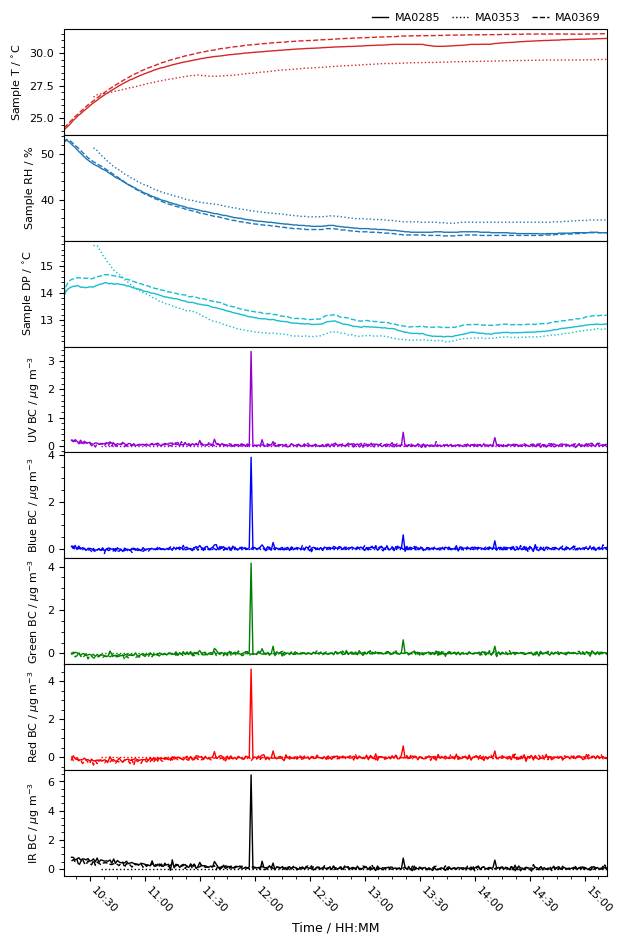

In [59]:
fig = plt.figure(figsize = (7, 11))
gs = fig.add_gridspec(8, hspace=0)
ax = gs.subplots(sharex=True)

for i, df_key in enumerate(conc_keys):
    for ls, dict_key in zip(line_styles, HEPA_keys):
        plot_total(ax[i], data[dict_key], df_key, colors[i], ls)
        ax[i].set_ylabel(ylabels[i], fontsize = 8)

ax[7].legend(labels = ['MA0285', 'MA0353', 'MA0369'], bbox_to_anchor = (0, 7.2, 1, 1), ncol = 3, fontsize = 8)

fig.tight_layout()
fig.savefig('HEPA_timeseries.png', dpi = 600)